In [1]:
import numpy as np
from math import tan, pi
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm 

In [2]:
# load tomography and iasp model
data_korean = np.loadtxt("Koreavel.xyz", skiprows=1)
deep    = data_korean[:,2]
d = deep >= 40.0
P_data_anonmal = data_korean[d,3] - data_korean[d,4] # delta Vp 
S_data_anonmal = data_korean[d,5] - data_korean[d,6] # delta Vs
    
S_data = data_korean[d,6]
adiabat = np.loadtxt('adiabat_pt.txt') # adiabatic temp from burnman
T_ref = np.loadtxt('reference_temp_c.txt', skiprows=1)
longitude = data_korean[d,0]
latitude = data_korean[d,1]
depth    = data_korean[d,2]

# spike value cul-off to prevent converting very low temp and very high temp
for i in range(len(depth)):
    if (S_data_anonmal[i] > 0.201) :
        S_data_anonmal[i] =0.201
    elif (S_data_anonmal[i] < -0.201) :
        S_data_anonmal[i] =-0.201    
#print(max(S_data_anonmal), min(S_data_anonmal))

In [3]:
print (len(np.unique(depth)), len(np.unique(latitude)), len(np.unique(longitude)))

18 101 95


In [4]:
# define mineral physics constants used in this study
## The table is from Fabio et al., 2003
data = np.array([('ol', 0.82, 4.2, 1.4, -0.017e9, -0.014e9, 129e9, 81e9, 3222, 0.201e-4, 0.139e-7, 0.1627e-2, 
                   1.658e2, 0.2332e-2, -0.3971e7) , 
                 ('opx', 0.144, 7, 1.6, -0.027e9, -0.012e9, 109e9, 75e9, 3215, 0.3871e-4, 0.0446e-7, 0.03435e-2, 
                   1.855e2, 0.233e-2, -0.6326e7) , 
                 ('gt', 0.036, 4.4, 1.4, -0.019e9, -0.01e9, 171e9, 92e9, 3565, 0.0991e-4, 0.1165e-7, 1.0624e-2, 
                  1.44e2, 0.188e-2, -0.135e7)], 
        dtype=[('name', 'U10'), ('conc', 'f4'), ('KPDer', 'f4'), ('MuPDer', 'f4'), 
        ('KTDer', 'f4'), ('MuTDer', 'f4'), ('K', 'f4'), ('Mu', 'f4'), ('rho', 'f4'), 
        ('a0', 'f4'), ('a1', 'f4'), ('a2', 'f4'), ('cp0', 'f4'), ('cp1', 'f4'), ('cp2', 'f4')])

## Anelasticity Parameter 
## There is original reference in Goes and Govers, 2000, Shallow mantle temperatures under Europe from P and S
## wave tomography, JGR, 97
A = 1.48e-1 ; H = 500e3; V = 20e-6; a = 0.15 ;d=1e-3
R = 8.314
grad_crust = -0.17; ## Yan et al., 2016, Stress development in heterogenetic lithosphere. Techtonophysics, 671, pp 56-62.
grad_crust2 = -0.25; ## Yan et al., 2016, Stress development in heterogenetic lithosphere. Techtonophysics, 671, pp 56-62.

We assume that for a fixed pressure $p_{0}$, density at temperature $T$ is determined with respect to a reference value at $T_{0}$ (Room temperature = 298.15 K, Fei and Saxena, 1988)as follows:
\begin{equation}
\rho(T_{pot}, P_0) = \rho(T_{pot}, P_0)\exp\left( -\int_{T_0}^{T_{pot}} \alpha(T)\ dT \right), \qquad \text{(eq.1)}
\end{equation}
where $\alpha$ is thermal expansion coefficient. 

Following [Fei and Saxena, 1988, Geochim. Cosmochim. Acta, 51, pp 251-254], [Saxena, 1988, J. Phys. Chem. Solids, 49, pp 1233-1235], [Saxena and Shen, 1992, JGR, 97, pp 19813-19825], the polynomial form of $\alpha$ is assumed to be
\begin{equation}
\alpha(T)=\alpha_0 + \alpha_1T + \alpha_2T^{-1} + \alpha_3T^{-2} + \ldots.
\end{equation}

The polynominal form is one of proposed models for function of themperature for thermal expansion coefficient [Kozu et al., 1934, Proc. Imp. Acad. Japan, 10, pp 83-86], [Skinner, 1957, Amer. Mineral, 42, pp 39-55], [Suzuki, 1975, J. Phys. Earth, 23, pp 145-159]. It has no physical meanings in $\alpha_{1}$ to $\alpha_{3}$. They are calculated by fitting experimental data in least square manner.

Plugging the polynomial form into eq. 1, we get
\begin{equation}
\rho(T_{pot}, P_0) = \rho(T_0, P_0) \exp \left(-(\alpha_0(T_{pot}-T_0) + \frac{1}{2}\alpha_1(T_{pot}-T_0)^2 + \alpha_2ln(T_{pot}-T_0) + ...) \right). \qquad \text{(eq.2a)}
\end{equation}

**[EC]**: I think we should get the following as eq.2b:
\begin{equation}
\rho(T_{pot}, P_0) = \rho(T_0, P_0) \exp \left(-\left[\alpha_{0}\,(T_{pot}-T_0) + \frac{1}{2}\alpha_{1}\,(T_{pot}^{2}-T_{0}^{2}) + \alpha_2\,(\ln(T_{pot})-\ln(T_{0})) + \ldots \right] \right). \qquad \text{(eq.2b)}
\end{equation}

**[LSH]**: The polynominal form is in per Kelvin. There is no source for temperature difference (T prime). So, eq 2b is correct if T prime is just absolute temperature. In addition, I think we are supposed to change T prime to T in eq. 1. 

In [5]:
def density(a0, a1, a2, rho0, T):
    T0 = 300.  # surface temperature and T should be potential temperature (1600 K)
    return (rho0 * np.exp (-a0 * (T - T0) - ( a1*(T - T0)**2 )/2 - a2*np.log (T - T0))) 

**[EC]** : We need the source for the equation, explanation for all the parameters used and the equation itself.

**[LSH]** : The eq. 3 and eq. 4 are from the third order Birch-Murnaghan equation of state [Birch, 1947, Phys. Review, 71, pp 809-824], [Fei, Y. 1995. Thermal expansion. In: Ahrens T.J. (ed.), pp 29-44]. The actual forms are using volume instead of density. Volume can be change to density because of mass conservation (mass is constant).

<!--$$P + (1+\epsilon)^{5/2}(3K\epsilon+0.5(9K(4-K')\epsilon^2 + ...)= 0 \dots (eq.3)$$-->
\begin{equation}
P + (1+\epsilon)^{5/2}\, \left( 3K\epsilon + \frac{1}{2}\,9K(4-K')\,\epsilon^2 + \ldots \right) = 0 \qquad \text{(eq.3)}
\end{equation}

<!--$$\rho(P, T) = (1-2\epsilon)^{3/2}\rho(P_0, T_{pot}) \dots (eq.4)$$-->
\begin{equation}
\rho(P, T)=(1-2\epsilon)^{3/2}\,\rho(P_0, T_{pot}) \qquad \text{(eq.4)}
\end{equation}

In [6]:
def derivative0 (f, x, h, P, K, Kdash):
    return (f(x+h, P, K, Kdash) - f(x-h, P, K, Kdash)) / (2.0*h) # might want to return a small non-zero if ==0

def epsilon(x, P, K, Kdash):
    return  ( (1 - 2*x) ** (5/2) ) * (3 * K * x + ( ( 9 * K * (4 - Kdash) )/ 2 ) * (x ** 2) )  + P 

def solve_ep (f, x0, h, P, K, Kdash):
    lastX = x0
    nextX = lastX + 10 * h  # "different than lastX so loop starts OK
    while (abs(lastX - nextX) > h):  # this is how you terminate the loop - note use of abs()
        newY  = epsilon(nextX,  P, K, Kdash)                     # just for debug... see what happens
        lastX = nextX
        nextX = lastX - newY / derivative0(f, lastX, h, P, K, Kdash)  # update estimate using N-R
    return nextX

In [7]:
x0 = 1.e-8
pressures = adiabat[:,0]
depth_a =  adiabat[:,1] / 1e3 # tomography is in m, easier for comparison
#T_a = adiabat[:,2]
T_r = T_ref[:,1] # reference temp with depth
strain = np.ones(len(pressures))
rho = np.ones(len(pressures))

# compositional dependence 
rho_avg = data['rho'][0] * data['conc'][0] + data['rho'][1] * data['conc'][1] + \
            data['conc'][2] * data['rho'][2]
K_avg = ( data['conc'][0] * data['K'][0] + data['conc'][1] * data['K'][1] + data['conc'][2]*data['K'][2])
Muavg = ( data['conc'][0] * data['Mu'][0] + data['conc'][1] * data['Mu'][1] + data['conc'][2]*data['Mu'][2])
KPDer_avg = ( data['conc'][0] * data['KPDer'][0] + data['conc'][1] * data['KPDer'][1] + \
          data['conc'][2]*data['KPDer'][2])

print(K_avg, Muavg, KPDer_avg)
for i in range (len(pressures)):
    strain[i]     = solve_ep (epsilon, x0, 1.e-15, pressures[i], K_avg, KPDer_avg) # equation to get x
    rho[i] = (( data['conc'][0] *  density ( data['a0'][0], data['a1'][0], data['a2'][0], data['rho'][0], 1600) ) 
    + ( data['conc'][1] *  density ( data['a0'][1], data['a1'][1], data['a2'][1], data['rho'][1], 1600) )
    + ( data['conc'][2] *  density ( data['a0'][2], data['a1'][2], data['a2'][2], data['rho'][2], 1600) ) ) \
    * ( ( 1 - ( 2 * strain[i] ) ) ** (3/2) )    
### Equation 3 means that density changes in pressure using polynomoal strain equation
### So, we can calculate density (P,T) at specific point

1.27632e+11 8.0532e+10 4.6104


In [8]:
# for i in range (len(pressures)):
#     print (depth_a[i], T_r[i], rho[i], strain[i])

**[LSH]** : Elastic moduli at high temperature can be obtained in a number of ways. A common scheme is to perform a Taylor expansion about a reference temperature as follows [Duffy and Anderson, 1989, JGR, 94, pp 1895-1912]:

\begin{equation}
M(T) = M(T_0) + \left(\left(\frac{\partial K}{\partial T}\right )_P+4/3\left(\frac{\partial G}{\partial T}\right )_P \right)(T-T_0) + 0.5\left(\left(\frac{\partial^2 K}{\partial T^2}\right )_P+4/3\left(\frac{\partial^2 G}{\partial T^2}\right )_P \right){(T-T_0)}^2 \qquad \text{(eq.5)} \qquad
G(T) = G(T_0) + \left(\frac{\partial G}{\partial T}\right )_P (T-T_0) + 0.5\left(\frac{\partial^2 G}{\partial T^2}\right )_P {(T-T_0)}^2 \qquad \text{(eq.6)}
\end{equation}

However, Fabio et al. (2003) are truncating terms at its second order. Then it rearrange eq. 5 and eq. 6 but also take limit then we can get the following as eq. 7 and eq. 8:

<!--$$ \partial M = \left(\left(\frac{\partial K}{\partial T}\right )_P+4/3\left(\frac{\partial G}{\partial T}\right )_P \right)(T-T_0) \dots (eq.6) $$-->
\begin{equation}
\partial M(T) = \left(\left(\frac{\partial K}{\partial T}\right )_P+4/3\left(\frac{\partial G}{\partial T}\right )_P \right)\partial T \approx  \left(\left(\frac{\partial K}{\partial T}\right )_P+4/3\left(\frac{\partial G}{\partial T}\right )_P \right)\Delta T \qquad \text{(eq.7)} \qquad \qquad 
\partial G(T) = \left(\frac{\partial G}{\partial T}\right )_P\partial T \approx \left(\frac{\partial G}{\partial T}\right )_P\Delta T \qquad \text{(eq.8)}
\end{equation}

**[LSH]** :Pressure derivative of a modulus($M^{\prime}(T)$) for high temperaure yeilds using Eq. 9 and Eq. 12 in [Duffy and Anderson, 1989, JGR, 94, pp 1895-1912]:

\begin{equation}
M'(T) = \left(\left(\frac{\partial K}{\partial P}\right )_T+4/3\left(\frac{\partial G}{\partial P}\right )_T \right)\exp(\int\limits_{T_0}^T \alpha(T)\ dT) \qquad \text{(eq.9)}
\end{equation}

**[LSH]** :Pressure derivative of a modulus($M^{\prime}(T)$) for high temperaure takes derivative to temperature and we can get following as eq. 10:

\begin{equation}
\partial M'(T) = \left(\left(\frac{\partial K}{\partial P}\right )_T+4/3\left(\frac{\partial G}{\partial P}\right )_T \right)\exp(\int\limits_{T_0}^T \alpha(T')\ dT')\alpha(T')\partial T \approx \qquad \left(\left(\frac{\partial K}{\partial P}\right )_T+4/3\left(\frac{\partial G}{\partial P}\right )_T \right)\exp(\int\limits_{T_0}^T \alpha(T')\ dT')\alpha(T')\Delta T \qquad \text{(eq.10)}
\end{equation}

In [9]:
# moduli plus temperature (potenttial) corrrection term 
def pmodT ( To, data, x, comp , ep ):
    T0=300
    Tp=1600
    return  ( data['K'][comp] + (4./3)*data['Mu'][comp] + 
             data['KTDer'][comp] * (Tp - To) + (4./3) * data['MuTDer'][comp] * (Tp - To) )

def smodT ( To, data, x, comp , ep ):
    T0=300
    Tp=1600
    return  ( data['Mu'][comp] + data['MuTDer'][comp] * (Tp - To) )

In [10]:
# temperature corrrection term for the moduli
def moduli ( To, data, x, comp):
    return  ( data['KTDer'][comp] * (x - To) + (4./3) * data['MuTDer'][comp] * (x - To) )

def s_moduli ( To, data, x, comp):
    return  ( data['MuTDer'][comp] * (x - To) )

In [11]:
def moduli_der0 ( To, data, x, comp , ep ):
    T0=300
    return ( data['KPDer'][comp] + (4/3) * data['MuPDer'][comp] ) *   \
           ( np.exp ( data['a0'][comp] * (x - T0) + ( data['a1'][comp] / 2 ) * (x - T0)**2) )

def smoduli_der0 ( To, data, x, comp , ep ):
    T0=300
    return ( data['MuPDer'][comp] ) *   \
           ( np.exp ( data['a0'][comp] * (x - T0) + ( data['a1'][comp] / 2 ) * (x - T0)**2) )

In [12]:
def moduli_der (To, data, x, comp):
    T0=300
    return ( data['KPDer'][comp] + (4/3) * data['MuPDer'][comp] ) *   \
           ( ( np.exp ( data['a0'][comp] * (x - T0) + ( data['a1'][comp] / 2 ) * (x - T0)**2) ) \
            * ( data['a0'][comp] + data['a1'][comp] * (x - T0) )  * ( x - To ) ) 

def smoduli_der (To, data, x, comp):
    T0=300
    return ( data['MuPDer'][comp] ) *   \
           ( ( np.exp ( data['a0'][comp] * (x - T0) + ( data['a1'][comp] / 2 ) * (x - T0)**2) ) \
            * ( data['a0'][comp] + data['a1'][comp] * (x - T0) )  * ( x - To ) ) 

### By definition of eq. 1, T0 is surface temp.
### However, eq. 7 is resulant of derivatives to temperaure difference 
### So, To means reference temp and X means perturbation temp

Finally, the moduli at the selected P, T conditions are determined from [Davies, 1973. J. Phys. Chem. Solids, 34, pp. 1417-1429], [Davies, 1974. J. Phys. Chem. Solids, 35, pp. 1513-1520] : 

\begin{equation}
M = (1-2\epsilon)^{5/2}\left\{M(T)+ \epsilon [5M(T)-3K(T)\left(\frac{\partial K}{\partial P} -(4/3) \frac{\partial G}{\partial P}\right ) - 3K(T)M'(T)] \right\} \qquad \text{(eq.11)}
\end{equation}

\begin{equation}
G = (1-2\epsilon)^{5/2}\left\{G(T)+ \epsilon [5G(T)-3K(T)\frac{\partial G}{\partial P}- 3K(T)G'(T)] \right\} \qquad \text{(eq.12)}
\end{equation}

Finally, the moduli at the selected P, T conditions take delivative to temperature and then we can get following eq. 13 and eq. 14

\begin{equation}
\partial M = (1-2\epsilon)^{5/2}\left\{\frac{\partial M(T)}{\partial T}\partial T+ \epsilon [5\frac{\partial M(T)}{\partial T}\partial T-3\frac{\partial K(T)}{\partial T} \left ( \frac{\partial K}{\partial P} -(4/3) \frac{\partial G}{\partial P}\right )\partial T - 3K(T)\partial M'(T)] \right\} \qquad \text{(eq.13)}
\end{equation}

\begin{equation}
\partial G = (1-2\epsilon)^{5/2}\left\{\frac{\partial G(T)}{\partial T}\partial T+ \epsilon [5\frac{\partial G(T)}{\partial T}\partial T-3\frac{\partial K(T)}{\partial T}  \frac{\partial G}{\partial P}\partial T - 3K(T)\partial G'(T)] \right\} \qquad \text{(eq.14)}
\end{equation}


## LSH (IMPORTANT) : I think moduli would be function of temperature in above four equations but I am not hundred percent sure whether the moduli are function of temperature or not in eq. 11 to eq 14. In Fabio (2003), it dose not seem that moduli are function of temperature.


In [13]:
# P, T function for K and mu 
def pmodPT ( To, data, x, comp , ep ):
    return ( ( 1 - 2*ep )**(5/2) ) * ( pmodT(data, x, comp) +
            ep * ( 5 * pmodT(data, x, comp)  - 3 * ( pmodT(data, x, comp) - (4/3)*smodT(data, x, comp) ) * \
                  ( moduli_der0 ( To, data, x, comp , ep ) ) ) ) 

def smodPT ( To, data, x, comp , ep ):  
    return ( ( 1 - 2*ep )**(5/2) ) * ( smodT( To, data, x, comp , ep )  +   \
            ep * ( 5 * smodT( To, data, x, comp , ep )  - 3 * ( pmodT( To, data, x, comp , ep ) - (4/3)*smodT( To, data, x, comp , ep ) ) *  \
                 ( smoduli_der0 ( To, data, x, comp , ep ) ) ) )

In [1]:
# P, T function for K and mu delivative to temperature difference
def p_modulus ( To, data, x, comp , ep ):   
    return ( ( 1 - 2*ep )**(5/2) ) * ( moduli ( To, data, x, comp)   +   \
            ep * ( 5 * moduli ( To, data, x, comp)  - 3 * ( data['KTDer'][comp] ) *  \
          ( x- To ) * ( data['KPDer'][comp]  + (4/3) * data['MuPDer'][comp] ) - 3 * data['K'][comp] *   \
            ( moduli_der (To, data, x, comp ) ) ) ) 

def s_modulus ( To, data, x, comp , ep ):   
    return ( ( 1 - 2*ep )**(5/2) ) * ( s_moduli ( To, data, x, comp)   +   \
            ep * ( 5 * s_moduli ( To, data, x, comp)  - 3 * ( data['KTDer'][comp] ) *  \
          ( x- To ) * (  data['MuPDer'][comp] ) - 3 * data['K'][comp] * (3/4) * \
            ( moduli_der (To, data, x, comp ) ) ) )  

In [15]:
def density_der(comp, rho, To, data, x, ep):
    T0=300
    Tp=1600
    return - data['rho'][comp] * np.exp (- data['a0'][comp] * (Tp - T0) - \
        ( data['a1'][comp] / 2) * (Tp - T0) ** 2  ) * ( data['a0'][comp] + data['a1'][comp] * (x - 300) ) * \
        ( x - To) * ( 1 - 2*ep )**(3/2.) 

In [16]:
# inversion for temperature
def double_derivative (f, x, h, delVp, ep, rho, To, data, P, Vso, Vpo):
    return (f(x+h, delVp, ep, rho, To, data, P, Vso, Vpo) + f(x-h, delVp, ep, rho, To, data, P, Vso, Vpo) -
            2 * f(x-h, delVp, ep, rho, To, data, P, Vso, Vpo) ) / (h**2)  

def derivative (f, x, h, delVp, ep, rho, To, data, P, Vso, Vpo):
    return (f(x+h, delVp, ep, rho, To, data, P, Vso, Vpo) - f(x-h, delVp, ep, rho, To, data, P, Vso, Vpo)  ) / (2 * h)

In order to calculate p and s-wave velocity, we use equations (P and S wave) for velocity delivative to temperature [Goes and Grovers, 2000, JGR, 150, pp 11,153-11,169]

\begin{equation}
\partial V / \partial T=  \partial V_{anh} / \partial T +\partial V_{ane} / \partial T \qquad \text{(eq.15)}
\end{equation}

In thoeretically, it yeilds following equations that We times $\partial T$ to eq.15 and we add an anomally of observed velocity to it :

\begin{equation}
\partial V_{anh} +\partial V_{ane} - Observed \, V anomally = 0 \qquad \text{(eq.16)}
\end{equation}

Under the assumption of adiabatic compression, the fourth-order finite-strain equations of [Davies, 1973. J. Phys. Chem. Solids, 34, pp. 1417-1429] and [Davies, 1974. J. Phys. Chem. Solids, 35, pp. 1513-1520] can be written in a form convenient for comparison with seismological data:

\begin{equation}
\rho {V_p}^2 = (1-2\epsilon)^{5/2}\left\{M(T) + \epsilon [5M(T)-3K(T)\left(\frac{\partial K}{\partial P} -(4/3) \frac{\partial G}{\partial P}\right ) - 3K(T)M'(T)] \right\} = M \qquad \text{(eq.17)}
\end{equation}

\begin{equation}
\rho {V_s}^2 = (1-2\epsilon)^{5/2}\left\{G(T)+ \epsilon [5G(T)-3K(T)\frac{\partial G}{\partial P}- 3K(T)G'(T)] \right\}  = G \qquad \text{(eq.18)}
\end{equation}

Eq. 17 and Eq. 18 can be written by taking delitivative to temperature in folloing forms :

\begin{equation}
\partial V_p = \frac{1}{\sqrt \rho} \frac{1}{2\sqrt {K+4G/3}}\partial (K+4G/3)-\frac {\sqrt {K+4G/3}}{2 \rho^{3/2}} \partial \rho + {Q_p}^-1\frac{aH}{2RT^2 \tan {\frac {\pi a}{2}}}(T-T_r) \qquad \text{(eq.19)}
\end{equation}

\begin{equation}
\partial V_s = \frac{1}{\sqrt \rho} \frac{1}{2\sqrt G}\partial G-\frac {\sqrt G}{2 \rho^{3/2}} \partial \rho + {Q_s}^-1\frac{aH}{2RT^2 \tan {\frac {\pi a}{2}}}(T-T_r) \qquad \text{(eq.20)}
\end{equation}

The third terms in Eq. 19 and Eq 20 are from Appendix A2 in [Goes and Grovers, 2000, JGR, 150, pp 11,153-11,169]

$$ where, $$


$$Q_p^{-1} = \left (1-4/3 \left (\frac{V_s}{V_p} \right )^2 \right )Q_k^{-1} + 4/3 \left (\frac{V_s}{V_p} \right )^2 \left ( Aw^a\exp \left (\frac {a(E+PV)}{RT}  \right ) \right )^{-1} \dots (eq.21) $$

$$Q_s^{-1} = \left ( Aw^a\exp \left (\frac {a(E+PV)}{RT}  \right ) \right )^{-1} \dots (eq.22) $$

In [17]:
def temperature_p ( x, delVp, ep, rho, To, data, P, Vso, Vpo):
    p_modulus0 = K_avg + (4/3)*Muavg     
    return ( 1/(2 * np.sqrt(rho_avg * p_modulus0) ) ) * ( data['conc'][0] *  p_modulus ( To, data, x, 0 , ep ) +
            data['conc'][1] *  p_modulus ( To, data, x, 1 , ep ) + data['conc'][2] *
            p_modulus ( To, data, x, 2 , ep ) ) - ( ( np.sqrt(p_modulus0)/( 2 * ( (rho_avg) ** 3/2 ) ) ) * \
            ( data['conc'][0] * density_der (0, rho, To, data, x , ep) +  data['conc'][1] * 
             density_der (1, rho, To, data, x, ep) + data['conc'][2] * density_der (2, rho, To, data, x, ep ) ) ) \
             + ( ( a * H * (4/3) * (Vso/Vpo)**2 ) * ( ( A * ( ( 2*np.pi )**a ) * 
             np.exp ( a * ( H + P*V ) / ( R * To ) ) ) ** -1 ) /(2 * R * ( To ** 2) * np.tan ( np.pi * a/2 ) ) ) \
             * (x - To) - delVp

In [18]:
def temperature_s ( x, delVs, ep, rho, To, data, P, Vso, Vpo):
    data['KPDer'][:] = 0;
    return ( 1/(2 * np.sqrt(rho * (data['conc'][0] * smodPT (To, data, x, 0 , ep) + data['conc'][1] * smodPT (To, data, x, 1 , ep) + data['conc'][2] * smodPT (To, data, x, 2 , ep))) ) ) * (data['conc'][0] * ( s_modulus ( To, data, x, 0 , ep ) +
            data['conc'][1] *  s_modulus ( To, data, x, 1 , ep ) + data['conc'][2] *
            s_modulus ( To, data, x, 2 , ep ) ) ) - ( ( np.sqrt((data['conc'][0] * smodPT (To, data, x, 0 , ep) + data['conc'][1] * smodPT (To, data, x, 1 , ep) + data['conc'][2] * smodPT (To, data, x, 2 , ep)))/( 2 * ( rho ** 3/2 ) ) ) * \
            ( data['conc'][0] * density_der (0, rho, To, data, x , ep) +  data['conc'][1] * 
             density_der (1, rho, To, data, x, ep) + data['conc'][2] * density_der (2, rho, To, data, x, ep ) ) ) \
             + ( ( a * H ) * ( ( A * ( ( 2*np.pi )**a ) * 
             np.exp ( a * ( H + P*V ) / ( R * To ) ) ) ** -1 ) /(2 * R * ( To ** 2) * np.tan ( np.pi * a/2 ) ) ) \
             * (x - To) - delVs

#     s_modulus0 = Muavg  
#     data['KPDer'][:] = 0 ;
#     return ( 1/(2 * np.sqrt(rho * s_modulus0) ) ) * (data['conc'][0] * ( s_modulus ( To, data, x, 0 , ep ) +
#             data['conc'][1] *  s_modulus ( To, data, x, 1 , ep ) + data['conc'][2] *
#             s_modulus ( To, data, x, 2 , ep ) ) ) - ( ( np.sqrt(s_modulus0)/( 2 * ( rho ** 3/2 ) ) ) * \
#             ( data['conc'][0] * density_der (0, rho, To, data, x , ep) +  data['conc'][1] * 
#              density_der (1, rho, To, data, x, ep) + data['conc'][2] * density_der (2, rho, To, data, x, ep ) ) ) \
#              + ( ( a * H ) * ( ( A * ( ( 2*np.pi )**a ) * 
#              np.exp ( a * ( H + P*V ) / ( R * To ) ) ) ** -1 ) /(2 * R * ( To ** 2) * np.tan ( np.pi * a/2 ) ) ) \
#              * (x - To) - delVs

**[LSH]** I've change temperaure_s because I think modulus would be function of temperature. I want to talk this issue.

In [19]:
def solve_T (f, x0, h, delVp, ep, rho, To, data, P, Vso, Vpo):
    lastX = x0
    nextX = lastX +  10 * h  # "different than lastX so loop starts OK
    while (abs(lastX - nextX) > h):  # this is how you terminate the loop - note use of abs()        
        newY  = f (nextX, delVp, ep, rho, To, data, P, Vso, Vpo)          # just for debug... see what happens
#         print (newY)     # print out progress... again just debug
        lastX = nextX
        nextX = lastX -  f (nextX,  delVp, ep, rho, To, data, P, Vso, Vpo) / derivative(f, lastX, h,  delVp, ep, rho, To, data, P, Vso, Vpo)  # update estimate using N-R
    return nextX

In [20]:
To = np.ones(len(depth)) ; ep_cal = np.ones(len(depth))
rho_cal = np.ones(len(depth)); T = np.ones(len(depth)) 
P = np.ones(len(depth)) 

In [21]:
# invert for temperatures
x0 = 500;
depth_a =  adiabat[:,1] / 1e3 # tomography is in m, easier for comparison
T_a = adiabat[:,2]
Vp_o  = data_korean[:,5]*1.e3
Vs_o  = data_korean[:,5]*1.e3

for i in range(len(depth)):
    To[i]      = (T_ref[:,1][5.0 >= np.abs(depth[i]-T_ref[:,0])].max()) # reference temperature with depth
    ep_cal[i]  = strain [5.0 >= np.abs(depth[i]-depth_a)].max()
    P[i]       = (pressures[5.0 >= np.abs(depth[i]-depth_a)].max())
    rho_cal[i] = rho [5.0 >= np.abs(depth[i]-depth_a)].max()
    
# equation to get x
    T[i]     = solve_T (temperature_s, x0, 1,  S_data_anonmal[i]*1e3, ep_cal[i], rho_cal[i], To[i], data, P[i], 
                        Vs_o[i], Vp_o[i])

    if np.mod((i+9597), 9597)== 0:
        print(To[i], Vs_o[i], ep_cal[i], rho_cal[i], depth[i])
        
#     for j in range(10): # Non-linear loop 
#         if j==0:
#             T[i]     = solve_T (temperature_s, x0, 1,  S_data_anonmal[i]*1e3, ep_cal[i], rho_cal[i], To[i], data, P[i], Vs_o[i], Vp_o[i])     
#             k_avg=(data['conc'][0]*(p_modulus0(data, To[i], 0 , ep_cal[i])-4/3*s_modulus0(data, To[i], 0 , ep_cal[i]))+
#                    data['conc'][1]*(p_modulus0(data, To[i], 1 , ep_cal[i])-4/3*s_modulus0(data, To[i], 1 , ep_cal[i]))+
#                    data['conc'][2]*(p_modulus0(data, To[i], 2 , ep_cal[i])-4/3*s_modulus0(data, To[i], 2 , ep_cal[i])))
#             KPDer_avg=(data['conc'][0]*(moduli_der0(data, T[i], 0 )-4/3*smoduli_der0(data, T[i], 0))+
#                        data['conc'][1]*(moduli_der0(data, T[i], 1)-4/3*smoduli_der0(data, T[i], 1))+
#                        data['conc'][2]*(moduli_der0(data, T[i], 2)-4/3*smoduli_der0(data, T[i], 2)))  
#             N_strain[i]     = solve_ep (epsilon, ep0, 1.e-15, P[i], K_avg, KPDer_avg) # equation to get strain
#         else:
#             T[i]     = solve_T (temperature_s, T[i], 1,  S_data_anonmal[i]*1e3, N_strain[i], rho_cal[i], To[i], data, P[i], Vs_o[i], Vp_o[i])     
#             k_avg=(data['conc'][0]*(p_modulus0(data, T[i], 0 , N_strain[i])-4/3*s_modulus0(data, T[i], 0 , N_strain[i]))+
#                    data['conc'][1]*(p_modulus0(data, T[i], 1 , N_strain[i])-4/3*s_modulus0(data, T[i], 1 , N_strain[i]))+
#                    data['conc'][2]*(p_modulus0(data, T[i], 2 , N_strain[i])-4/3*s_modulus0(data, T[i], 2 , N_strain[i])))
#             KPDer_avg=(data['conc'][0]*(moduli_der0(data, T[i], 0 )-4/3*smoduli_der0(data, T[i], 0))+
#                        data['conc'][1]*(moduli_der0(data, T[i], 1)-4/3*smoduli_der0(data, T[i], 1))+
#                        data['conc'][2]*(moduli_der0(data, T[i], 2)-4/3*smoduli_der0(data, T[i], 2)))            
#             lastN = N_strain[i]
#             N_strain[i]     = solve_ep (epsilon, ep0, 1.e-15, P[i], K_avg, KPDer_avg)

1760.04 4851.469 -0.029428034416 3342.90915453 399.35
1750.468 4816.612 -0.0280947286729 3330.28898999 379.3175
1740.896 4781.756 -0.0267429510157 3317.51023669 359.285
1731.324 4746.899 -0.0253720617459 3304.56755146 339.2525
1721.752 4712.043 -0.0239813847571 3291.45529099 319.22
1712.18 4677.186 -0.0225837434586 3278.29488593 299.1875
1702.608 4642.33 -0.0211789924477 3265.08525607 279.155
1695.234 4607.491 -0.0197530315789 3251.69437377 259.1225
1683.412 4573.035 -0.0183050563346 3238.11554337 239.09
1668.8281 4538.579 -0.0168342118813 3224.34165571 219.0575
1645.96 4515.805 -0.0153855552822 3210.79469306 199.025
1587.376 4511.798 -0.0139136667387 3197.04996524 178.9925
1485.842 4507.792 -0.0124176063046 3183.09967272 158.96
1344.502 4503.786 -0.0108963711637 3168.93550057 138.9275
1203.674 4499.74 -0.00934888965731 3154.54856982 118.895
1059.41 4495.027 -0.00777871998824 3139.97302839 98.8625
921.328 4490.313 -0.00618169667184 3125.17130968 78.83
780.672 4485.952 -0.00454899398271

In [22]:
T_results = np.loadtxt('initial_temperature_S_tomography_CC.txt', skiprows=4, usecols=3)

In [23]:
d_crust = (deep < 20.0) & (deep > 0.0)
lat_c = data_korean[d_crust, 1]
long_c = data_korean[d_crust, 0]
d_c = data_korean[d_crust, 2]
T_crust = ((data_korean[d_crust,5] - data_korean[d_crust,6]) * grad_crust)*1000 + 484.13

d_crust2 = (deep < 40.0) & (deep > 20.0)
lat_c2 = data_korean[d_crust2, 1]
long_c2 = data_korean[d_crust2, 0]
d_c2 = data_korean[d_crust2, 2]
T_crust2 = ((data_korean[d_crust2,5] - data_korean[d_crust2,6]) * grad_crust2)*1000 + 588.05

# print(max(T_crust), min(T_crust), max(T_crust2), min(T_crust2))

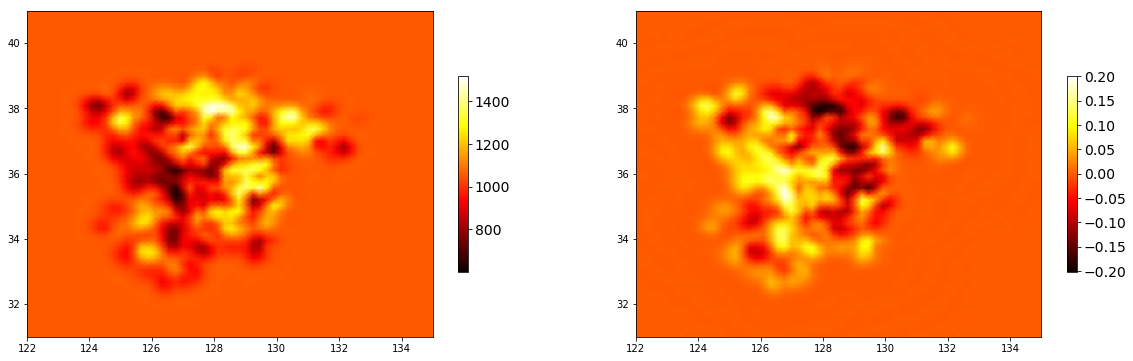

359.285
[  58.7975   78.83     98.8625  118.895   138.9275  158.96    178.9925
  199.025   219.0575  239.09    259.1225  279.155   299.1875  319.22
  339.2525  359.285   379.3175  399.35  ]


In [24]:
d_q = np.unique(depth)
d_cal   = np.reshape(depth,(len(d_q), 101, 95))
T_cal   = np.reshape(T, (len(d_q), 101, 95))
dVs_cal = np.reshape(S_data_anonmal , (len(d_q), 101, 95))
# Vp_cal = np.reshape(Vp, (len(d_q), npts, npts))

lat_cal = np.reshape(latitude,(len(d_q), 101, 95))
long_cal= np.reshape(longitude,(len(d_q), 101, 95))
n = 15
(fig, (ax1, ax2)) = plt.subplots(1, 2, figsize=(20,6))
plt.rcParams.update({'font.size': 14})
CB = ax1.pcolormesh(long_cal[n,:, :], lat_cal[n, :, :], T_cal[n ,:, :], cmap=cm.hot, shading='gouraud')
CB1 = ax2.pcolormesh(long_cal[n,:, :], lat_cal[n, :, :], dVs_cal[n ,:, :], cmap=cm.hot, shading='gouraud')
cbar = plt.colorbar(CB, shrink=0.6, ax=ax1)
cbar2 = plt.colorbar(CB1, shrink=0.6, ax=ax2)

CB.axes.set_xlim([122, 135])
CB.axes.set_ylim([31, 41])
CB1.axes.set_xlim([122, 135])
CB1.axes.set_ylim([31, 41])
plt.show()
print(np.unique(depth)[n])
print(np.unique(depth))

In [25]:
print (d_q[14])

339.2525


In [26]:
# addting two buffer layer for crust (18.8 km and 38.8 km)

T_c = np.concatenate([ T, T_crust2, T_crust]);
lat = np.concatenate([latitude, lat_c2, lat_c])
longt = np.concatenate([longitude, long_c2, long_c])
depth_c = np.concatenate([depth, d_c2, d_c])
# T_c = np.concatenate([ T]);

# T_c = np.concatenate([ T, T_crust]);
# # T_a = np.concatenate([ AT, T_crust]);
# lat = np.concatenate([latitude, lat_c])
# longt = np.concatenate([longitude, long_c])
# depth_c = np.concatenate([depth,d_c])
# lat = np.concatenate([latitude])
# longt = np.concatenate([longitude])
# depth_c = np.concatenate([depth])

print (np.shape(lat ), np.shape(depth_c), np.shape(T_c))

r = (6370 - depth_c)*1e3
long_f = longt*np.pi/180
lat_f = (90 - lat)*np.pi/180
ind = np.lexsort((r, long_f, lat_f))
np.savetxt('initial_temperature_S_tomography_CC.txt', \
            np.stack((r[ind], long_f[ind], lat_f[ind], T_c[ind]), axis=-1))

(191900,) (191900,) (191900,)


In [27]:
min(T_c)
# print([S_data_anonmal == max(S_data_anonmal)])

335.81154502273131

In [28]:
print(long_f[ind])


[ 2.0442291   2.0442291   2.0442291  ...,  2.41226145  2.41226145
  2.41226145]
